In [2]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('once')

In [132]:
%%html
<style>
div.input {
    display:none;
}
</style>

In [4]:
all_files = glob.glob("ALL_RESULTS/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

results = pd.concat(li, axis=0, ignore_index=True, sort = True)
results.head()

,a0,a1,b0,b1,bayes_coeff_test_ce,bayes_coeff_test_ece,bayes_coeff_train_ce,bayes_coeff_train_ece,bayes_map_test_ce,bayes_map_test_ece,...,platt_train_ce,platt_train_ece,shift,sigma,smoothed_factor,smoothed_test_ce,smoothed_test_ece,smoothed_train_ce,smoothed_train_ece,tr_size
0,-2.5,0.0,0.0,0.5,0.443981,0.016670,0.433285,0.098764,0.443233,0.011447,...,0.426619,0.074969,NaN,1.0,"(0.03158578947368421, 0.015797894736842105)",0.454035,0.056131,0.426585,0.057537,100.0
1,-2.5,0.0,0.0,0.5,0.444396,0.014417,0.481398,0.092782,0.444277,0.013331,...,0.480331,0.074436,NaN,1.0,"(0.026323157894736843, 0.026323157894736843)",0.449634,0.035046,0.481005,0.066807,100.0
2,-2.5,0.0,0.0,0.5,0.449910,0.032388,0.422573,0.088504,0.448978,0.029374,...,0.421408,0.064706,NaN,1.0,"(0.015797894736842105, 0.021060526315789474)",0.449033,0.026627,0.421330,0.061080,100.0
3,-2.5,0.0,0.0,0.5,0.694616,0.035927,0.688255,0.113877,0.690962,0.014123,...,0.670772,0.013421,NaN,1.0,"(0.1, 0.07894947368421053)",0.703858,0.082094,0.670931,0.024061,100.0
4,-2.5,0.0,0.0,0.5,0.690851,0.014315,0.698926,0.102736,0.692235,0.027663,...,0.689871,0.003036,NaN,1.0,"(0.1, 0.1)",0.695258,0.038492,0.689985,0.008000,100.0


In [27]:
methods = ['normal', 'platt', 'cauchy_map', 'bayes_preds', 'bayes_coeff', 'bayes_map', 'l1', 'l2', 'smoothed', 'kde']
colors  = ['r', 'g', 'b', 'y', 'c', 'w', 'm', 'olivedrab', 'indigo', 'lime',]

### Methods Definition

1. Normal --> Vanilla Logistic Regression
2. Platt --> Platt Scaling
3. smoothed --> Label Smoothing with factor chosen based on 10-fold stratified cross-validation
4. l1 -->  L1 regularization for coefficients
5. l2 --> l2 regularization for coefficients
6. cauchy_map --> maximum aposteriori when using cauchy prior for coefficients (Gelman et al., 2008)
7. bayes_preds --> OPTIMAL: weighted average of predictions based on posterior probability of each logisitic function (Same prior as generative function is used)
8. bayes_coeff --> weighted average of coeff based on posterior probability of each logisitic function (Same prior as generative function is used)
9. bayes_map --> maximum aposteriori logistic function (Same prior as generative function is used)
10. kde --> Label smoothing using KDE

#### KDE Method:

$$ PF = PF_{POS} \times  \frac{PDF_{POS}}{PDF_{POS} + PDF_{NEG}}$$

$$ NF = PF_{NEG} \times  \frac{PDF_{POS}}{PDF_{POS} + PDF_{NEG}}$$

$NF$ = Negative class smoothing factor <br>
$PF$ = Positive class smoothing factor <br>
$PF_{Pos/Neg}$ = Platt smoothing factor for POS/NEG classes<br>
$PDF_{Pos/Neg}$ = Probability density function of drawing the sample from POS/NEG classes estimated distributions<br>

<img src="exp.png">

### Experiment Details:
1. Generative Distributions evaluated for means of positive and negative classes normal distributions are Beta / Uniform with different paramters
2. standard deviation of normal distributions is set to 1
3. Bernoulli distribution with p = 0.5, 0.7, 0.9 was used to set the class ratio (number of positive instances to negative instances)
4. Number of tranining set instances = 50, 100, and (500 currently running)
5. Number of testing set instances = 10,000
6. Beta/Uniform Generative models were used to draw 1,000 means for pos and negative classes
7. for each drawn pair of positive/negative means, we sample the training set three different times and take average of the experiment
8. LogLoss and Expected Calibration Error are calculated throughout the experiments

## Uniform Distribution

#### Positive to Negative Ratio = 0.5
#### a0 = -2.5, b0 = 0, a1 = 0, b1 = 2.5
#### Train_size = 50, 100

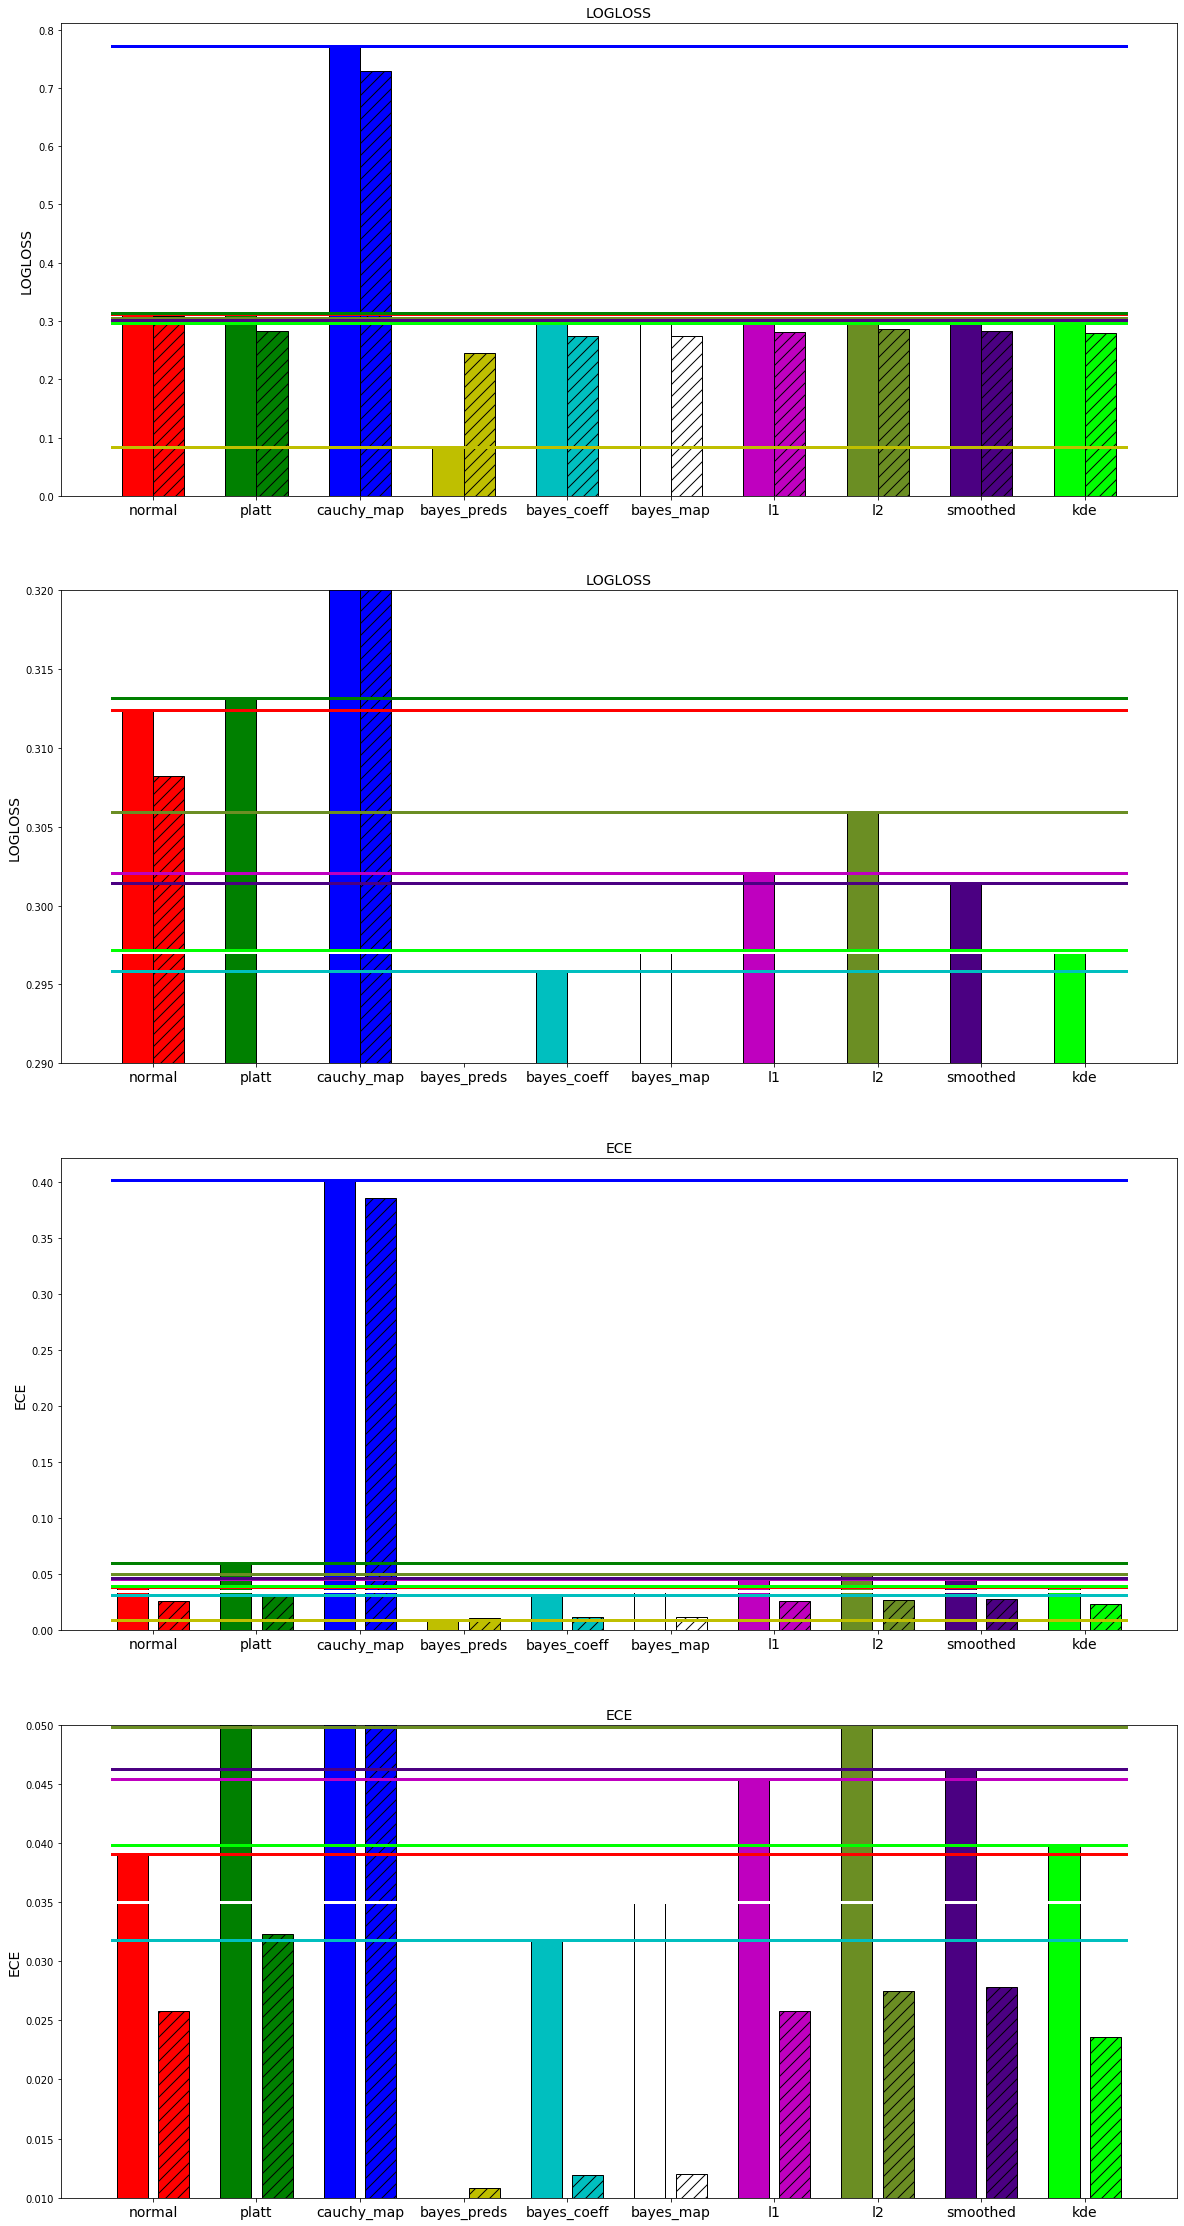

In [53]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.5)]
subresult100 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.5)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.29,ymax=0.32)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.01,ymax=0.05)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.7
#### a0 = -2.5, b0 = 0, a1 = 0, b1 = 2.5
#### Train_size = 50, 100

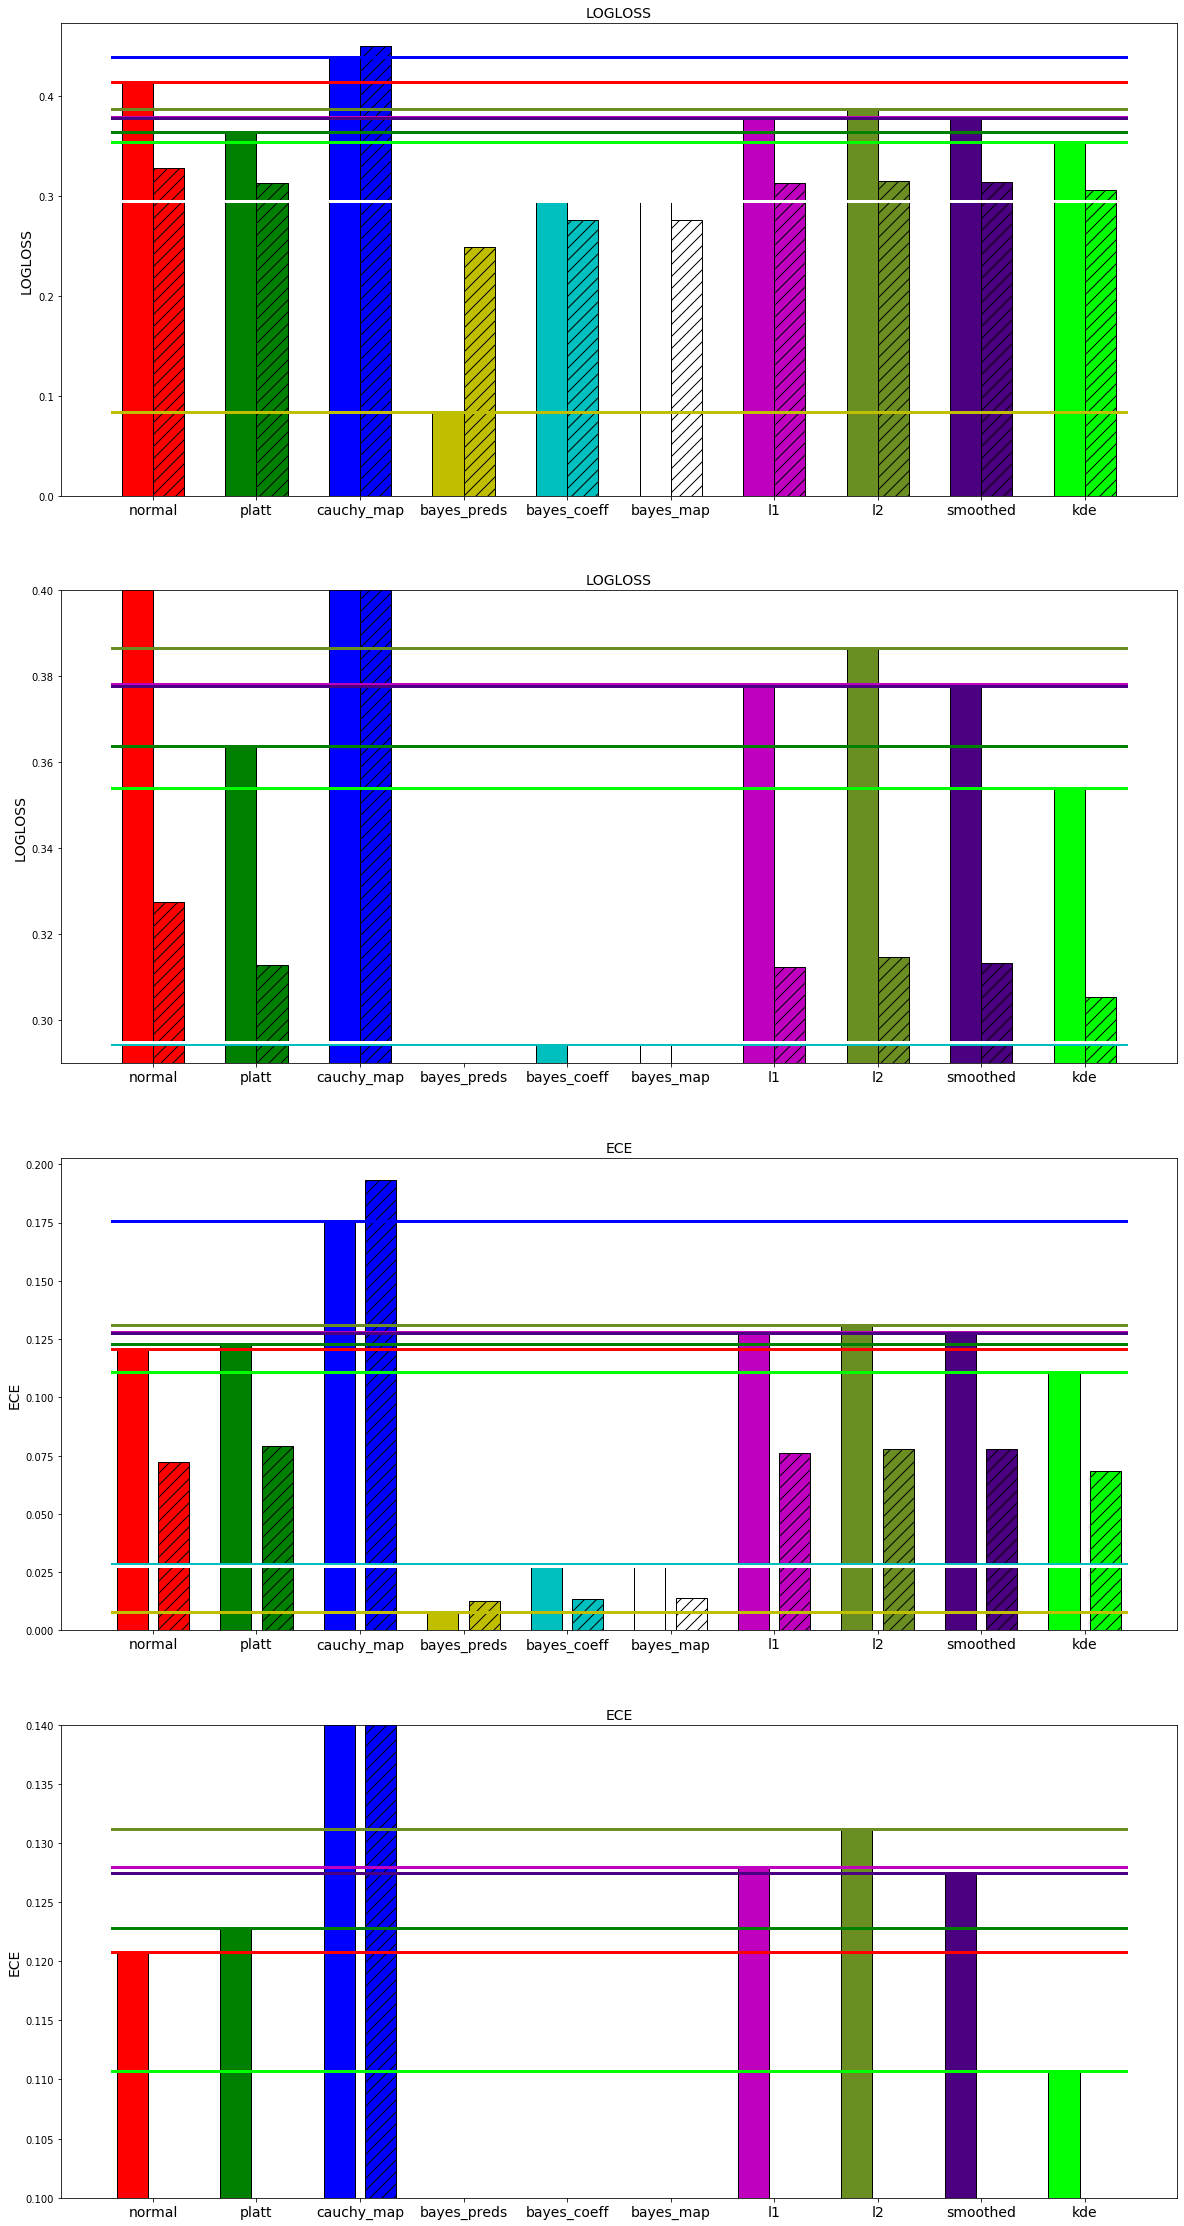

In [52]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.7)]
subresult100 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.7)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.29,ymax=0.4)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.1,ymax=0.14)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.9
#### a0 = -2.5, b0 = 0, a1 = 0, b1 = 2.5
#### Train_size = 50, 100

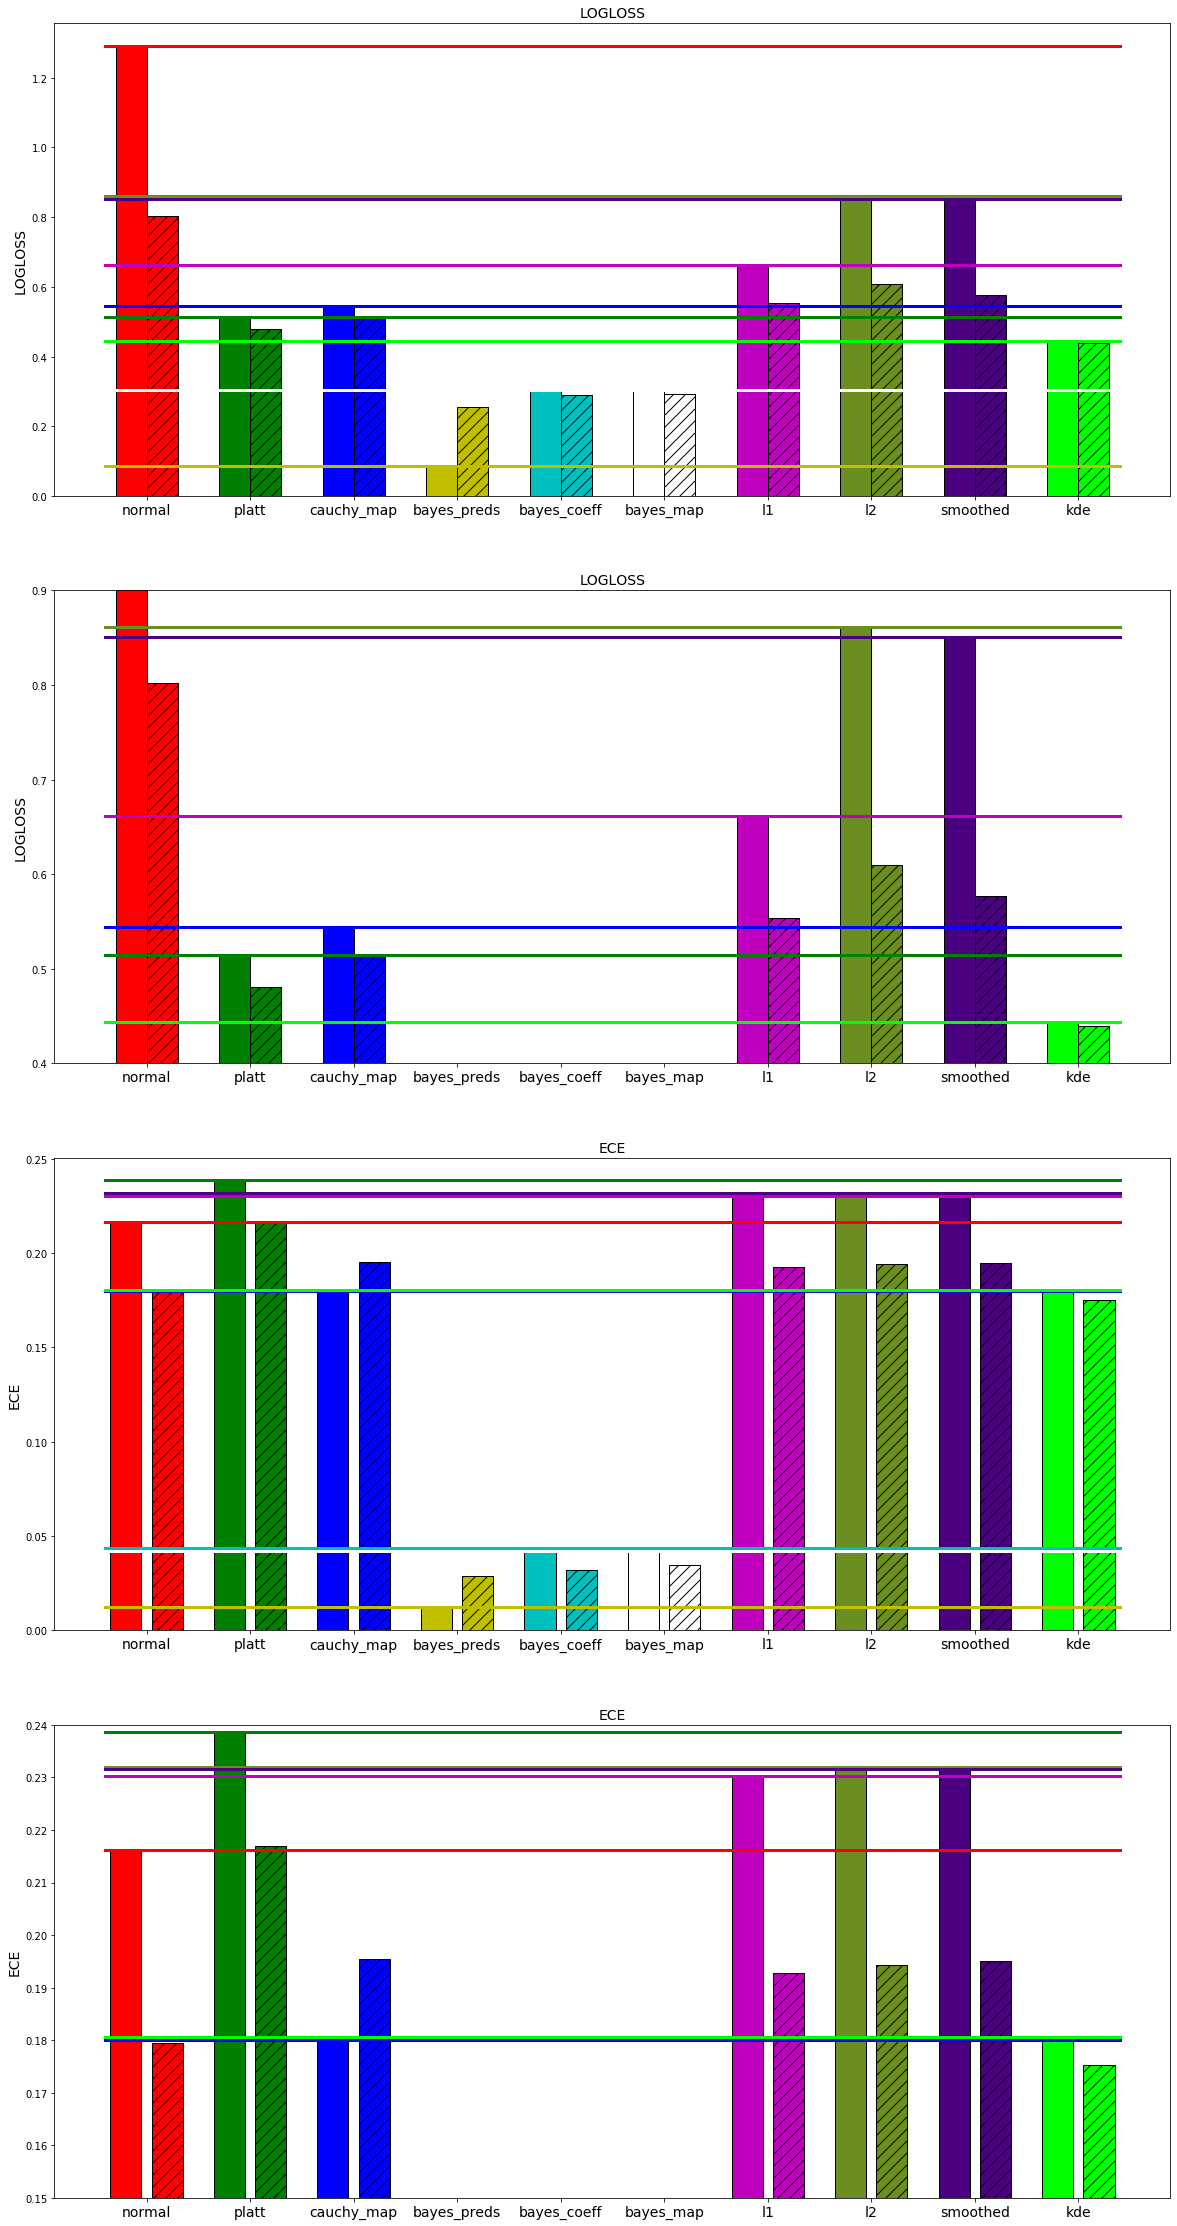

In [56]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.9)]
subresult100 = results[(results['distribution'] == 'uniform') & (results['a0'] == -2.5) & (results['b1'] == 2.5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.9)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.4,ymax=0.9)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.15,ymax=0.24)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Overall Rank

## Beta Distribution

#### Positive to Negative Ratio = 0.5
#### a0 = 2, b0 = 5, a1 = 5, b1 = 2, shift = 3
#### Train_size = 50, 100

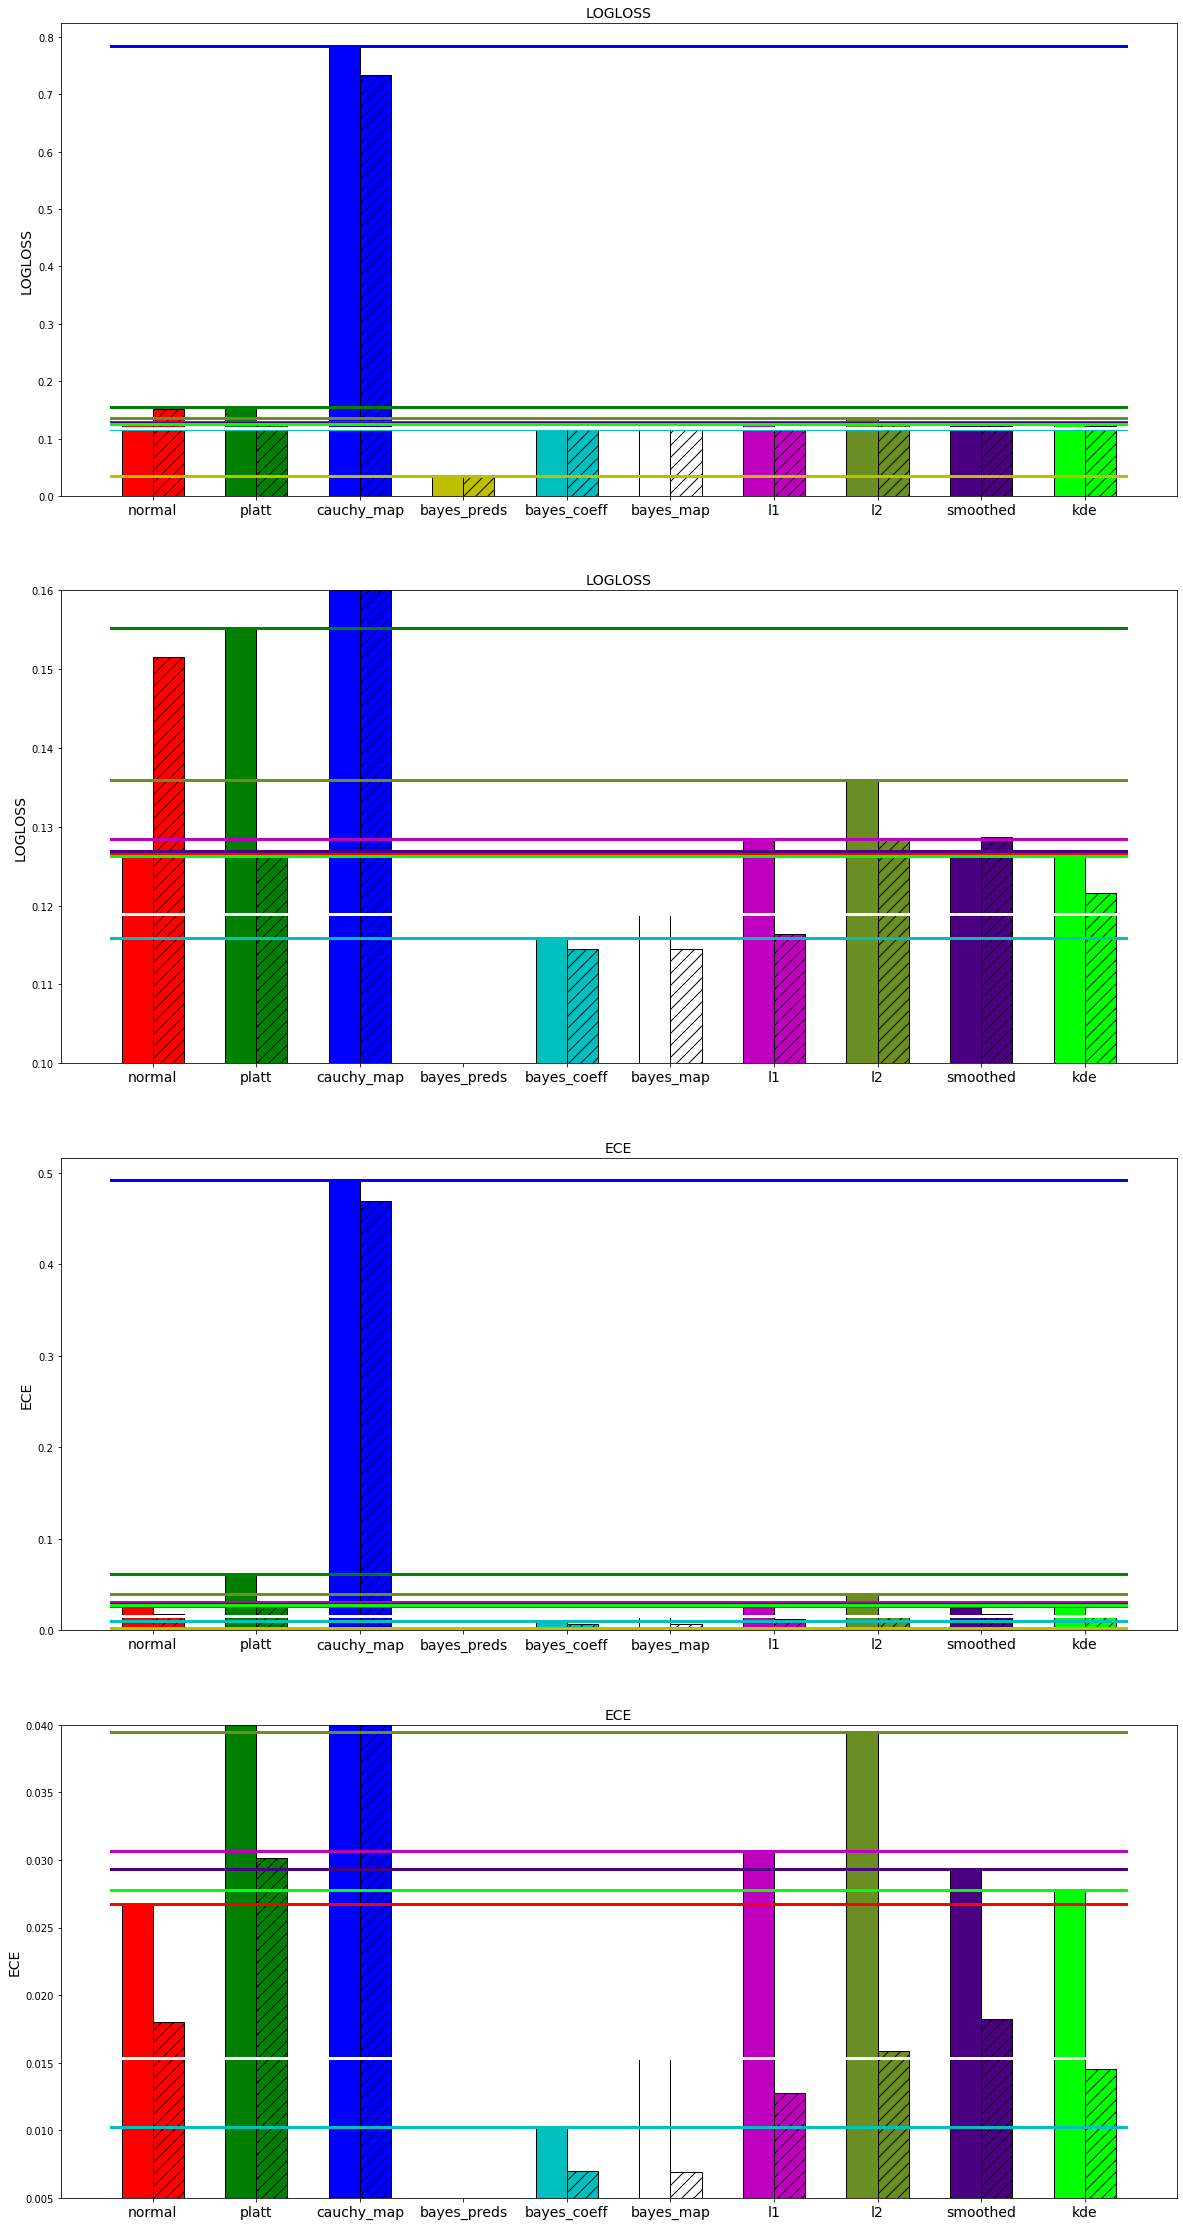

In [75]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.5) & (results['shift'] == 3)]
subresult100 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.5) & (results['shift'] == 3)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.1,ymax=0.16)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.005,ymax=0.04)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.5
#### a0 = 2, b0 = 5, a1 = 5, b1 = 2, shift = 1
#### Train_size = 50, 100

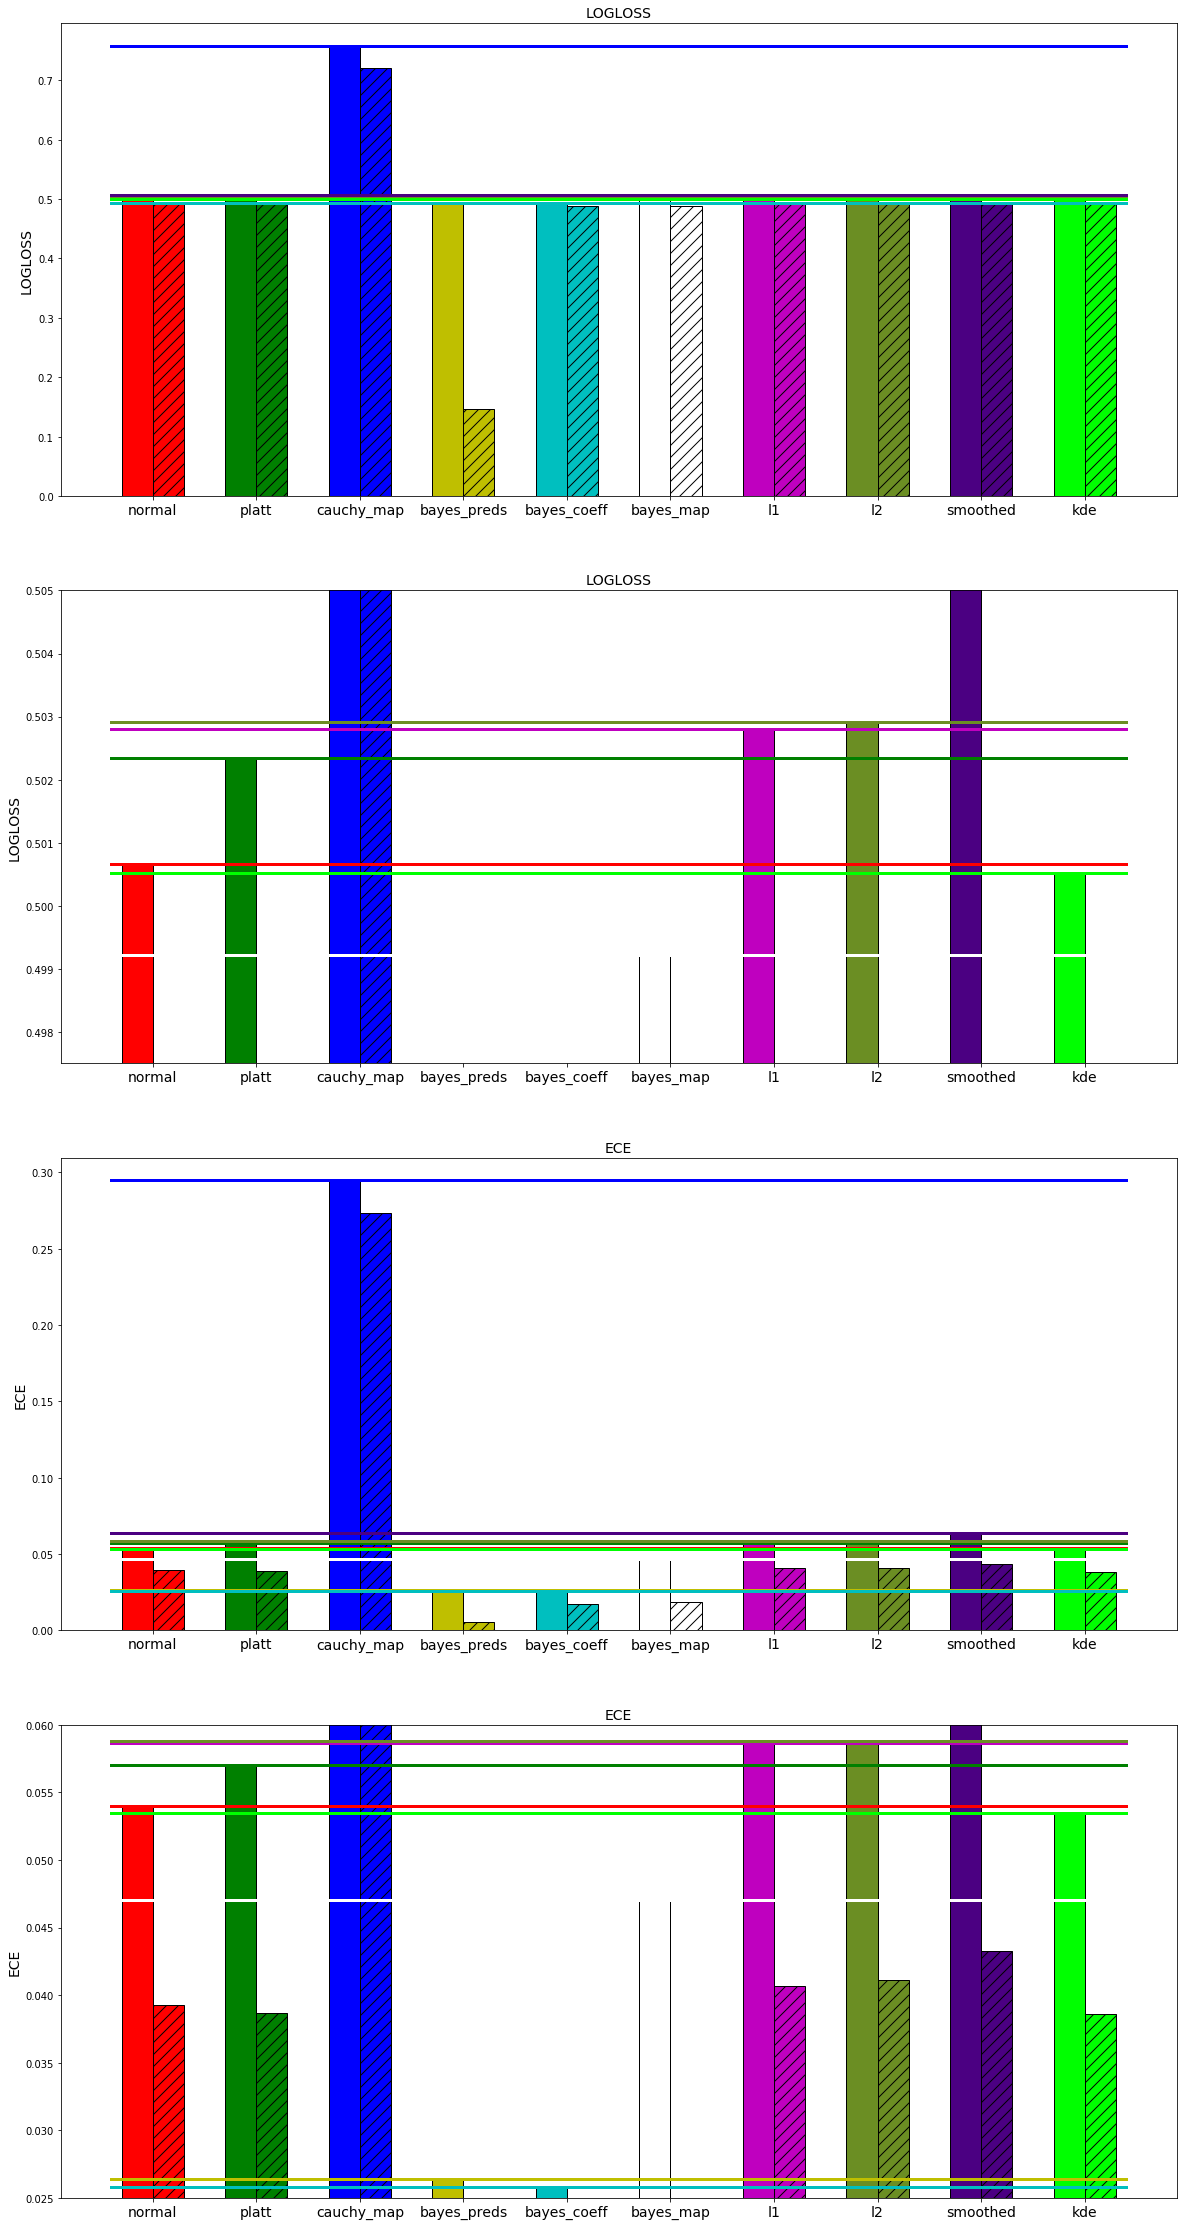

In [76]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.5) & (results['shift'] == 1)]
subresult100 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.5) & (results['shift'] == 1)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.4975,ymax=0.505)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.025,ymax=0.06)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.7
#### a0 = 2, b0 = 5, a1 = 5, b1 = 2, shift = 3
#### Train_size = 50, 100

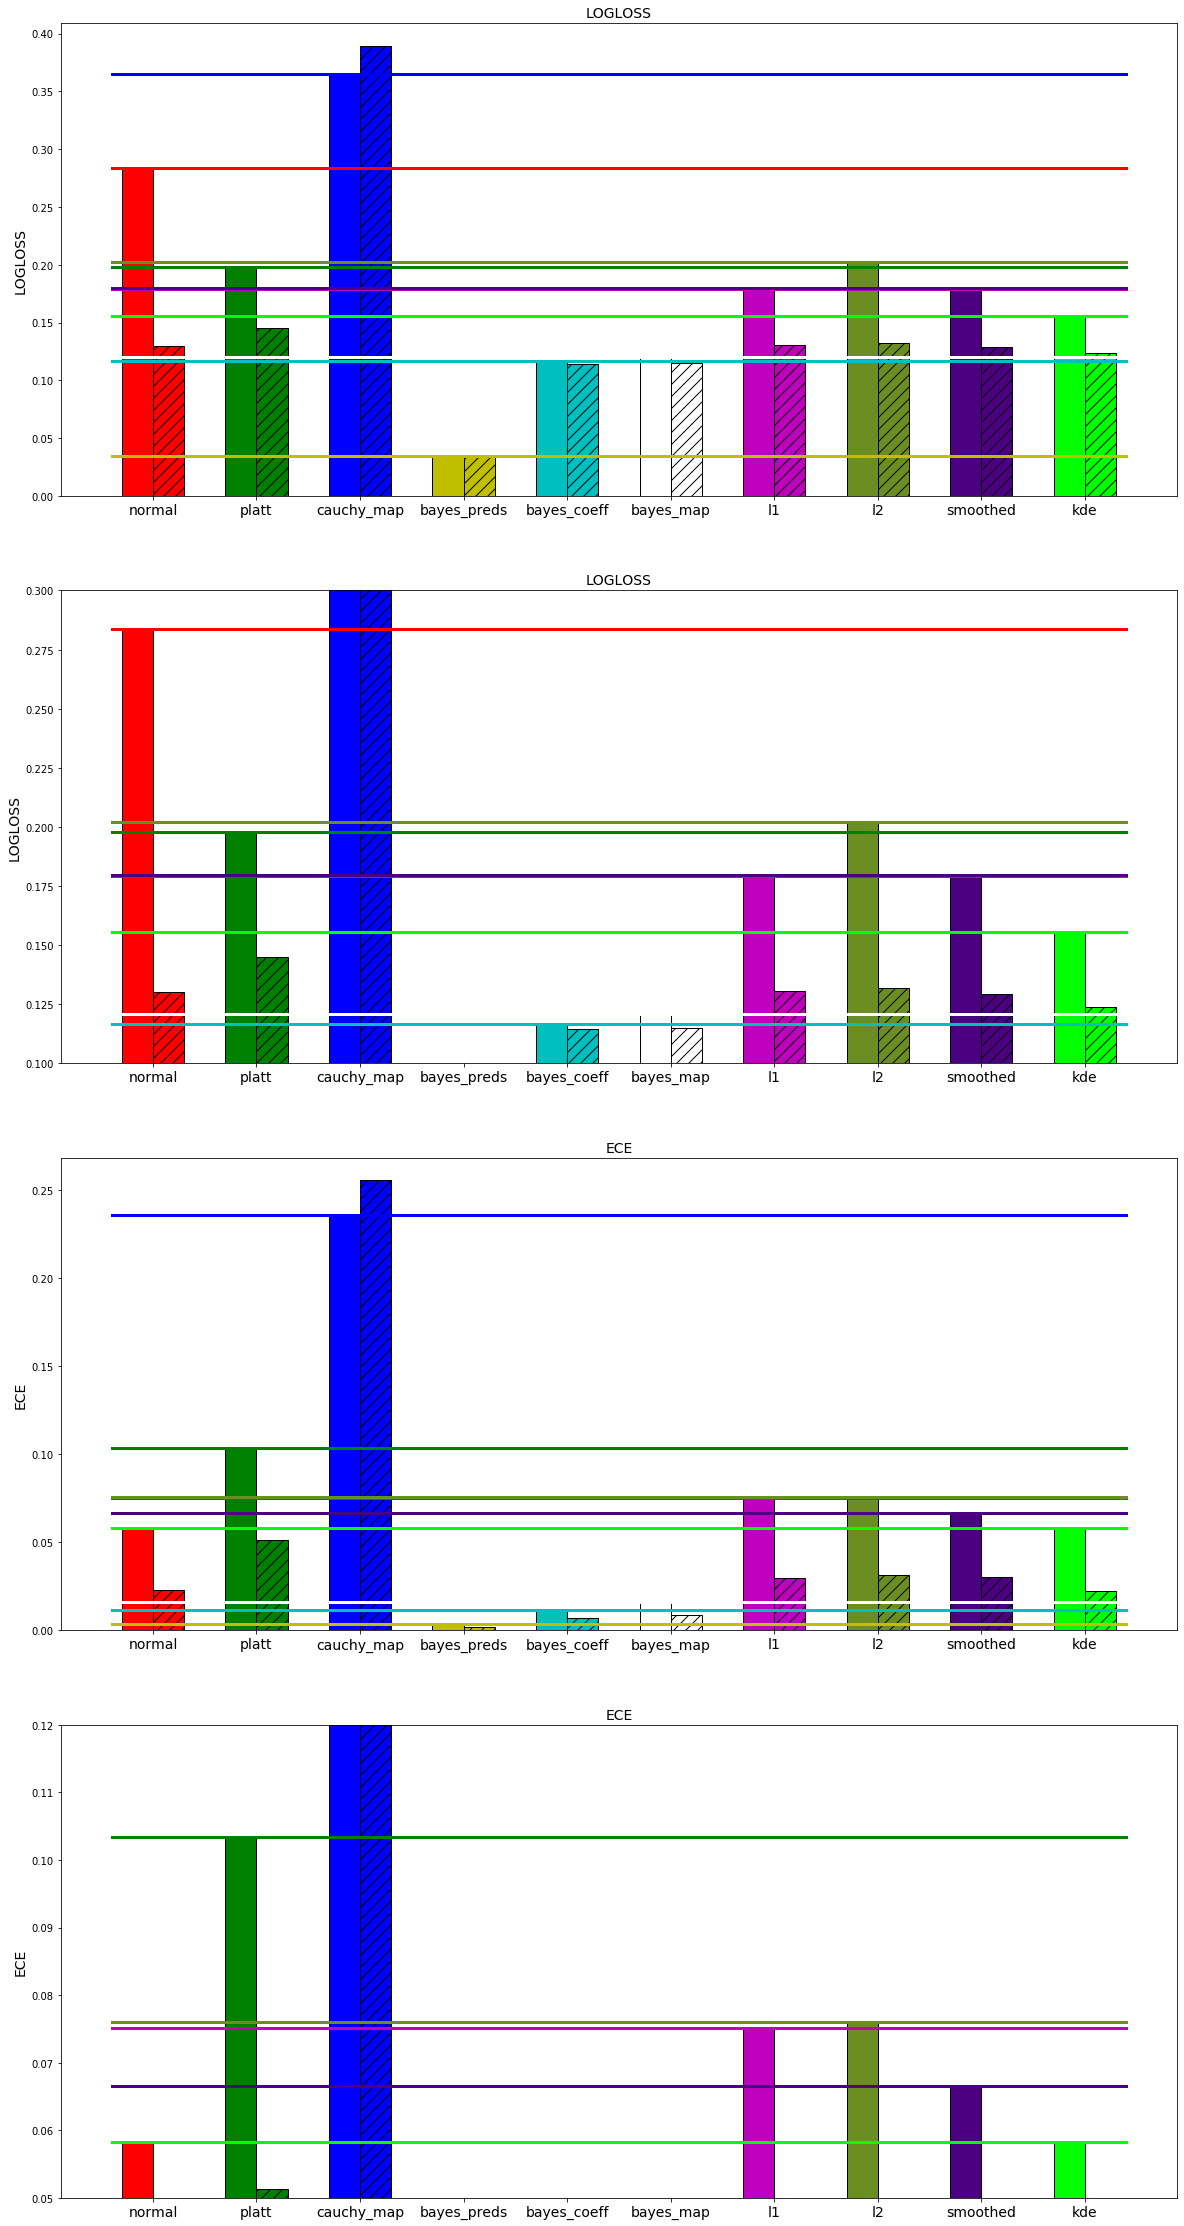

In [80]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.7) & (results['shift'] == 3)]
subresult100 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.7) & (results['shift'] == 3)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.1,ymax=0.3)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.05,ymax=0.12)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.9
#### a0 = 2, b0 = 5, a1 = 5, b1 = 2, shift = 3
#### Train_size = 50, 100

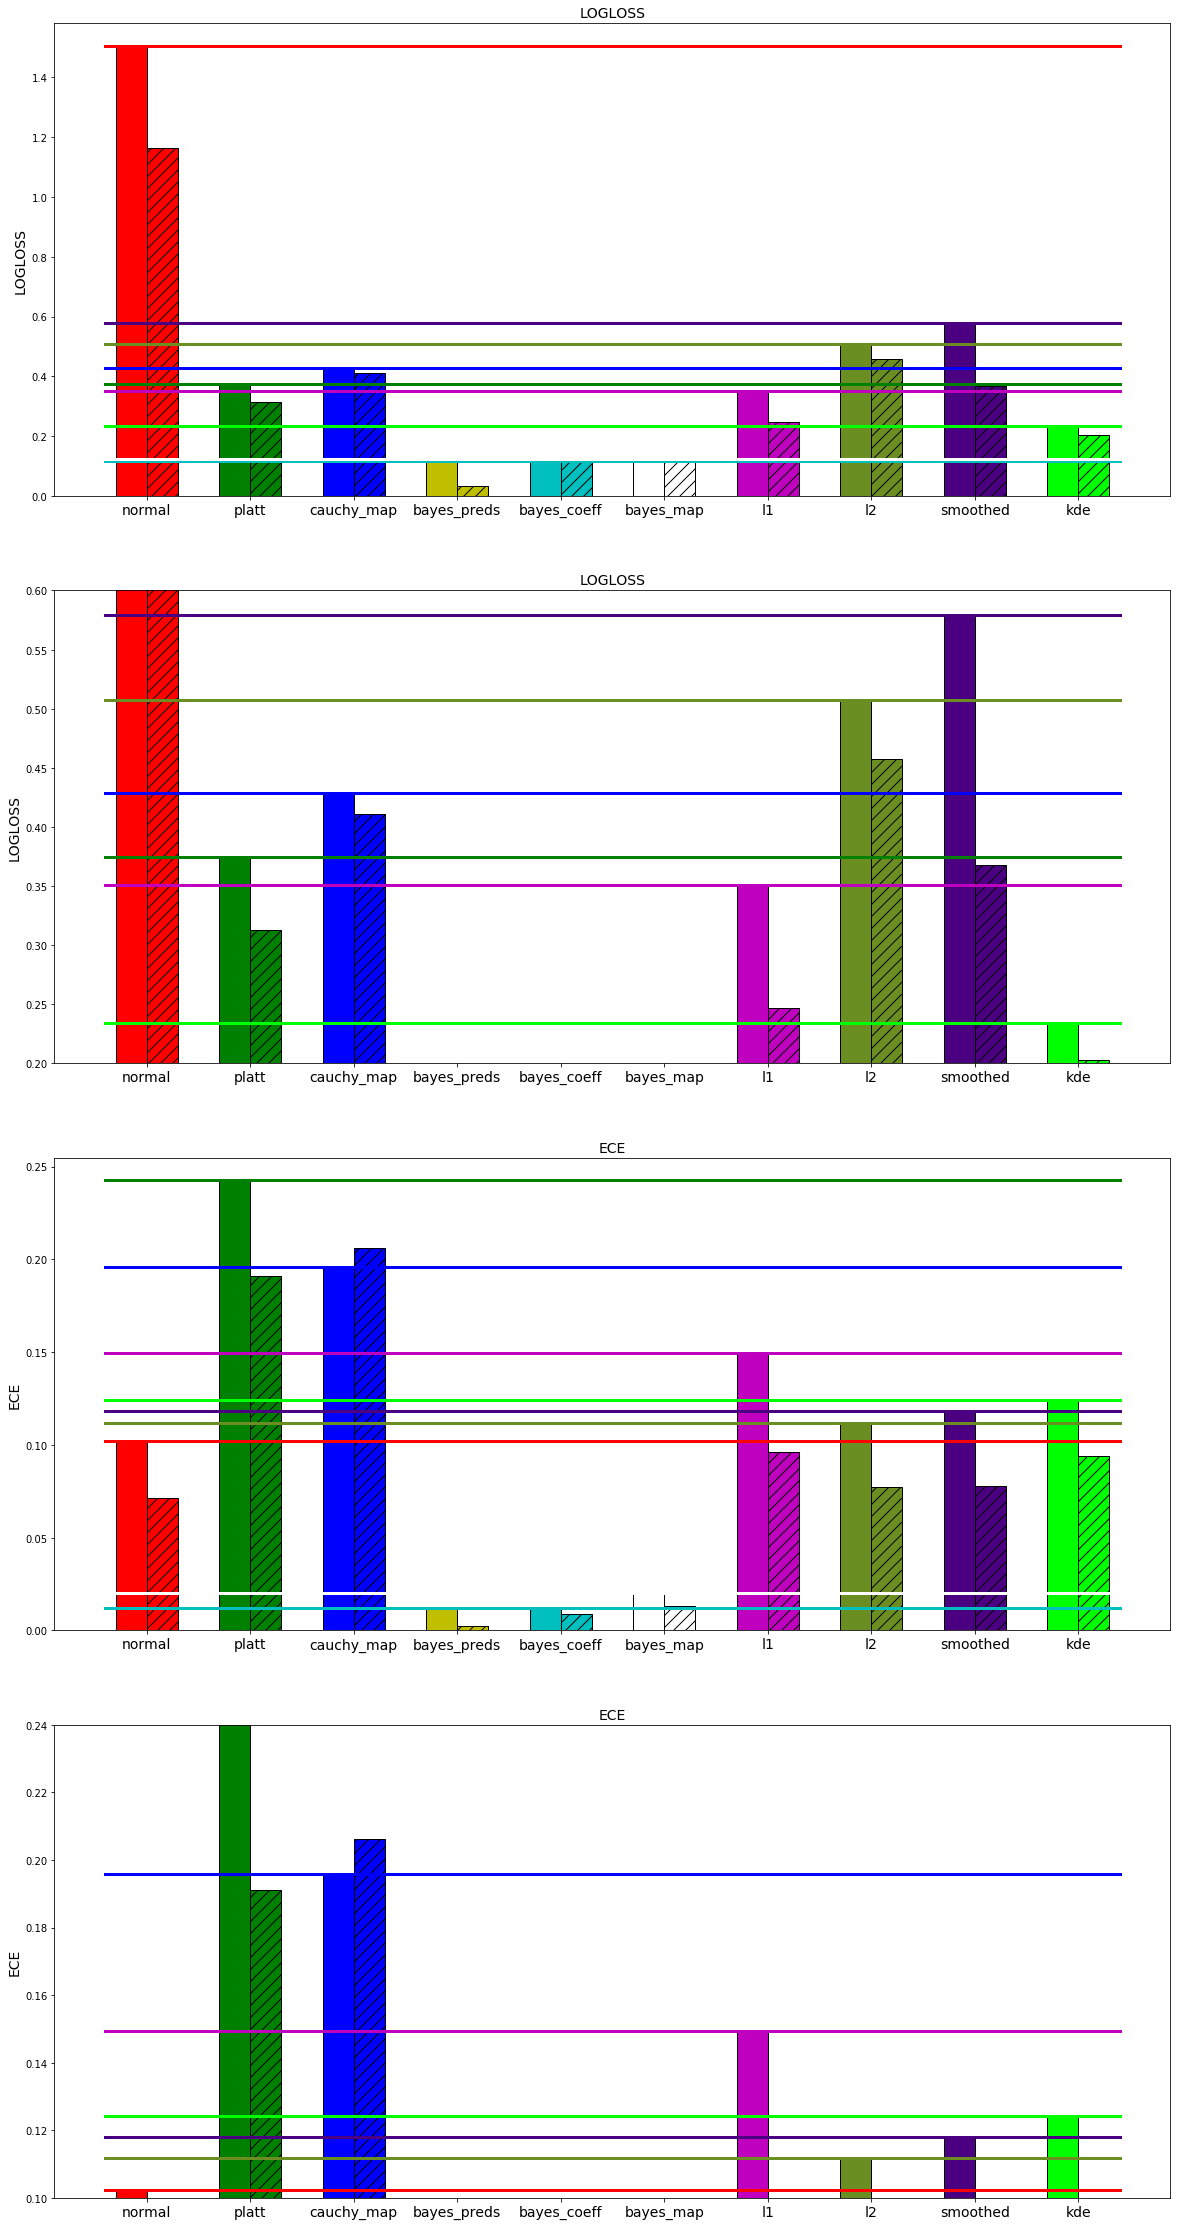

In [87]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.9) & (results['shift'] == 3)]
subresult100 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.9) & (results['shift'] == 3)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.2,ymax=0.6)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.1,ymax=0.24)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

#### Positive to Negative Ratio = 0.9
#### a0 = 5, b0 = 2, a1 = 2, b1 = 5, separation = 1
#### Train_size = 50, 100

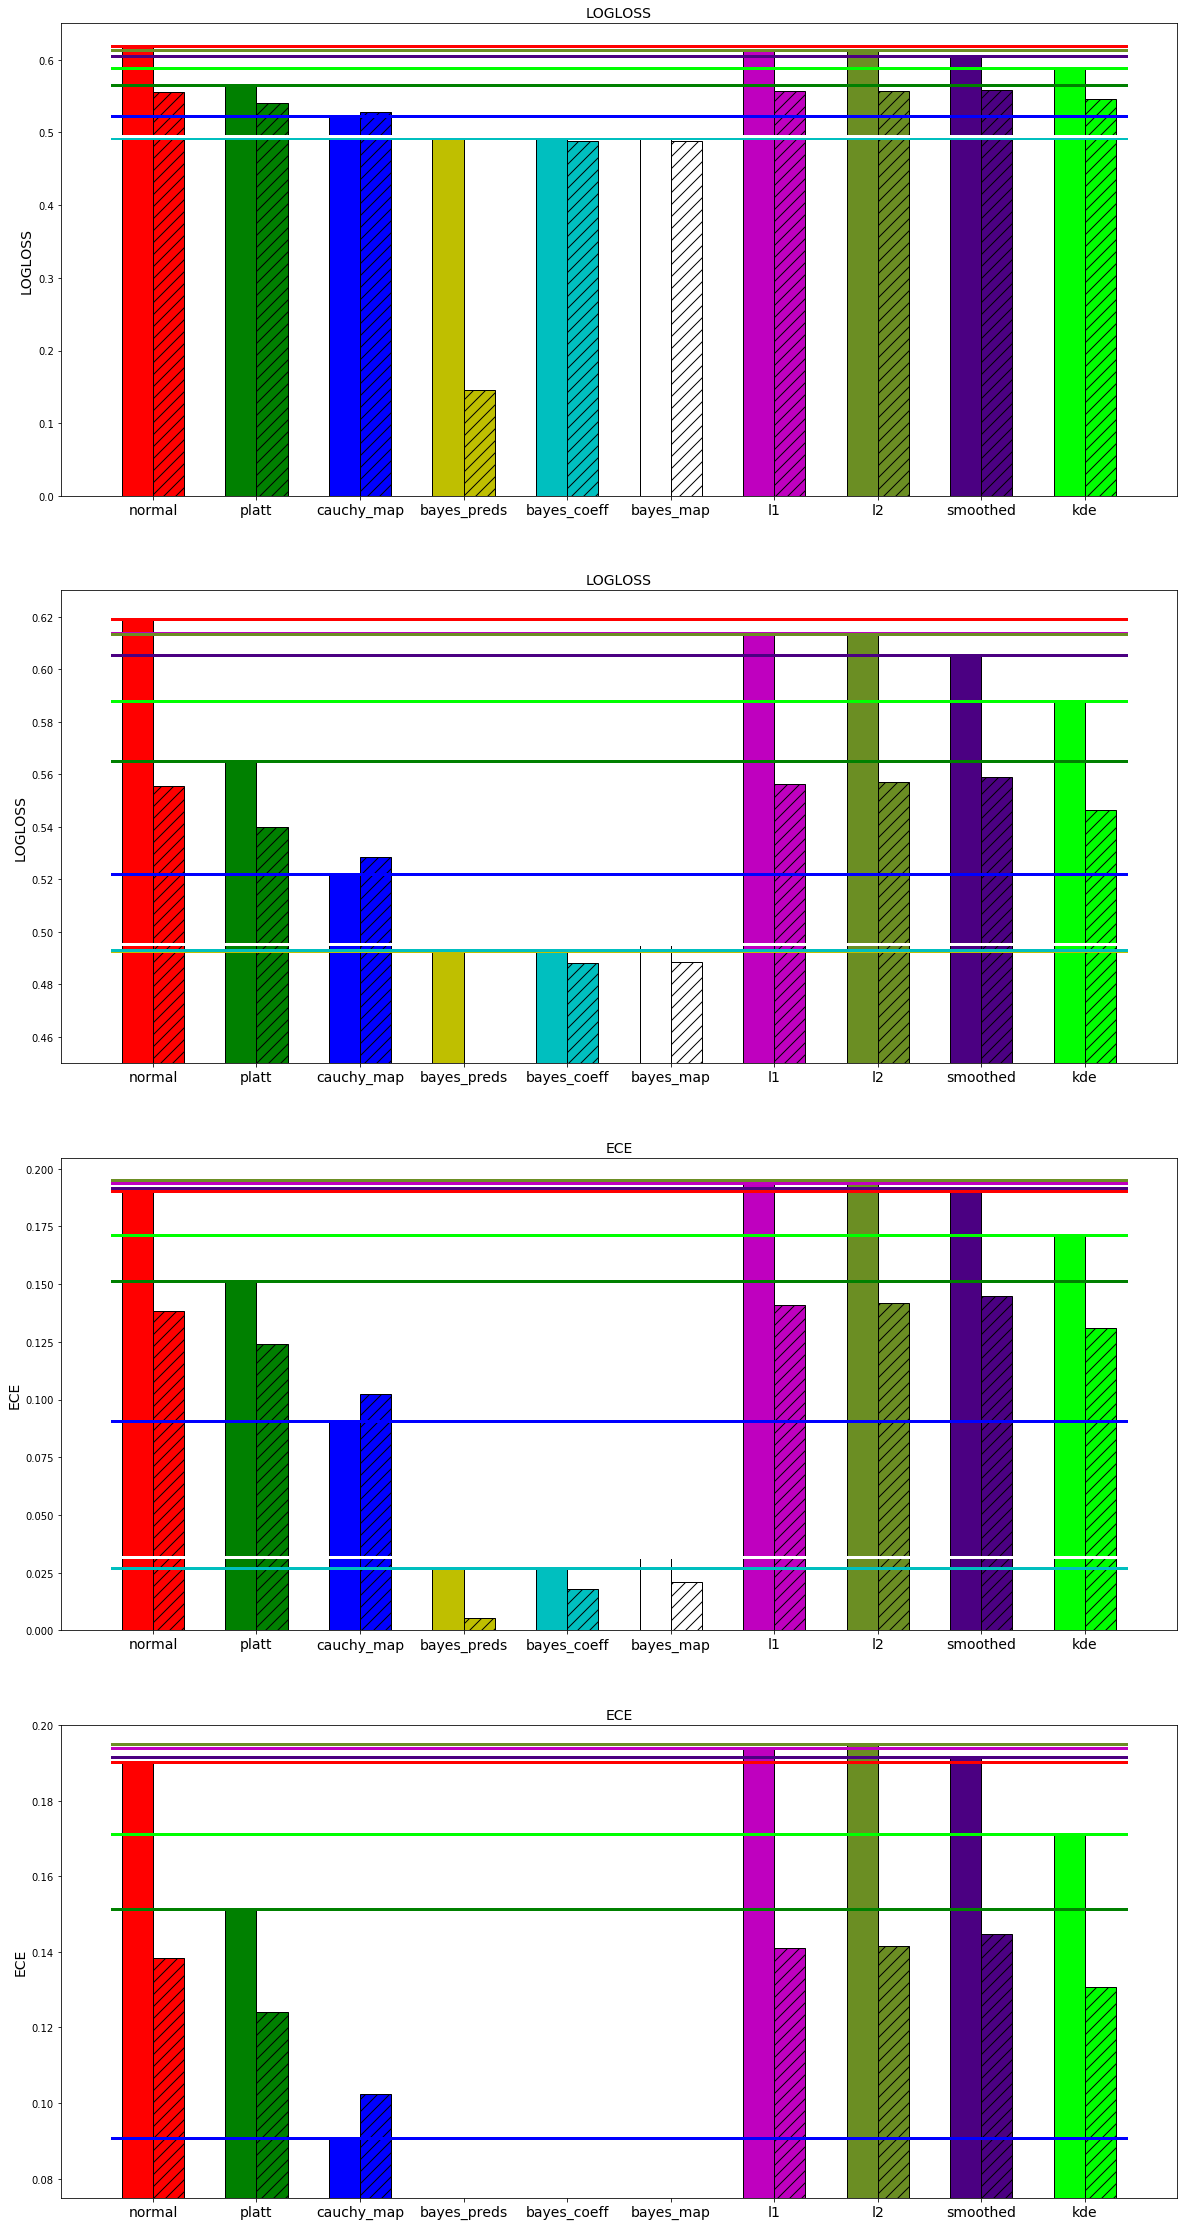

In [84]:
#plt.figure(figsize=(20,10))
y_pos = np.arange(len(methods))
titles = ['LOGLOSS', 'LOGLOSS', 'ECE', 'ECE']
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (20, 40))
axs = []
for axrow in ax:
    axs.append(axrow)

subresult50 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                      (results['tr_size'] == 50) & (results['clr'] == 0.7) & (results['shift'] == 1)]
subresult100 = results[(results['distribution'] == 'beta') & (results['b0'] == 5) & (results['a1'] == 5) & 
                       (results['tr_size'] == 100) & (results['clr'] == 0.7) & (results['shift'] == 1)]

performance50_ce = []; performance50_ece = []; performance100_ce = []; performance100_ece = []
for m in methods:
    performance50_ce.append(np.mean(subresult50[m + '_test_ce']))
    performance50_ece.append(np.mean(subresult50[m + '_test_ece']))
    performance100_ce.append(np.mean(subresult100[m + '_test_ce']))
    performance100_ece.append(np.mean(subresult100[m + '_test_ece']))

ax_0 = axs[0]; ax_1 = axs[1]; ax_2 = axs[2]; ax_3 = axs[3]
ax_0.set_title(titles[0], fontsize = 14); ax_1.set_title(titles[1], fontsize = 14);
ax_2.set_title(titles[2], fontsize = 14); ax_3.set_title(titles[3], fontsize = 14)
### 1st subplot ###
ax_0.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_0.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_0.set_xticks(y_pos) 
ax_0.set_xticklabels(methods, fontsize=14)
ax_0.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_0.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 2nd subplot ###
ax_1.bar(y_pos-0.15, performance50_ce, align='center', color = colors, width=0.3, edgecolor='k')
ax_1.bar(y_pos+0.15, performance100_ce, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_1.axis(ymin=0.45,ymax=0.63)
ax_1.set_xticks(y_pos) 
ax_1.set_xticklabels(methods, fontsize=14)
ax_1.set_ylabel('LOGLOSS', fontsize=14)
for p, c in zip(performance50_ce, colors):
    ax_1.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)
    
### 3rd subplot ###
ax_2.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_2.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_2.set_xticks(y_pos) 
ax_2.set_xticklabels(methods, fontsize=14)
ax_2.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_2.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

### 4th subplot ###
ax_3.bar(y_pos-0.15, performance50_ece, align='center', color = colors, width=0.3, edgecolor='k')
ax_3.bar(y_pos+0.15, performance100_ece, align='center', color = colors, width=0.3, hatch = '//', edgecolor='k')
ax_3.set_xticks(y_pos) 
ax_3.set_xticklabels(methods, fontsize=14)
ax_3.axis(ymin=0.075,ymax=0.2)
ax_3.set_ylabel('ECE', fontsize=14)
for p, c in zip(performance50_ece, colors):
    ax_3.plot([-0.4, 9.4], [p, p], color = c, linewidth = 3)

plt.show()

## Overall Rank

In [127]:
def avgRank(data, cols, rev = False):
    #replace missing values by inf
    data.fillna(1e9, inplace=True)
    ranks = np.zeros(shape = (len(data), len(cols)))
    for index, row in data.iterrows():
        perfs = [] #performance of each tool
        for c in cols:
            perfs.append(row[c + '_test_ce'])
        perfs_sorted = sorted(np.unique(perfs), reverse = rev) #sorted performance
                      
        for p in range(len(perfs)):
            for i in range(len(perfs_sorted)):
                if perfs[p] == perfs_sorted[i]:
                    ranks[index, p] = i + 1
                    break
    
    #convert to dataframe
    return pd.DataFrame(data=ranks, columns=cols)

#### Class Ratio = 1:1 --> p = 0.5

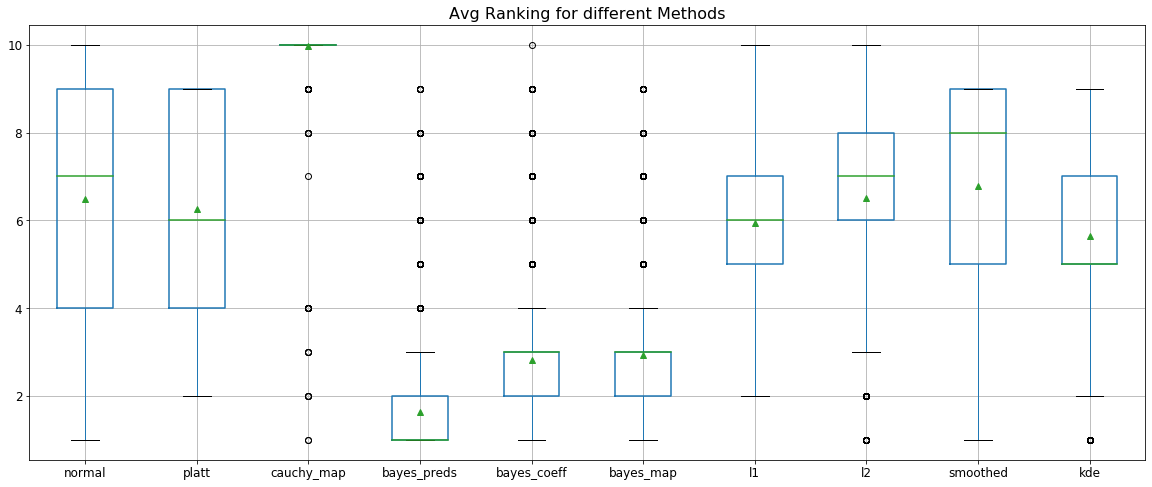

In [129]:
subresults1 = results[(results['clr'] == 0.5) & (results['tr_size'] == 100)]
subresults1.reset_index(drop=True, inplace=True)
avgRank_CE  = avgRank(subresults1, methods)
df = avgRank_CE
props = dict(boxes="b", whiskers="k", medians="k", caps="k", linewidth=2)
boxprops = dict(color="black",linewidth=1.5)
medianprops = dict(color="black",linewidth=1.5)
df.boxplot(grid = True, showmeans = True, notch = False, patch_artist=False, fontsize = 12, figsize=(20, 8),
           boxprops = boxprops, medianprops = medianprops)
           #color=props)

plt.title('Avg Ranking for different Methods', fontsize = 16)
plt.show()

#### Class Ratio  --> p = 0.7

C:\Users\s-moh\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


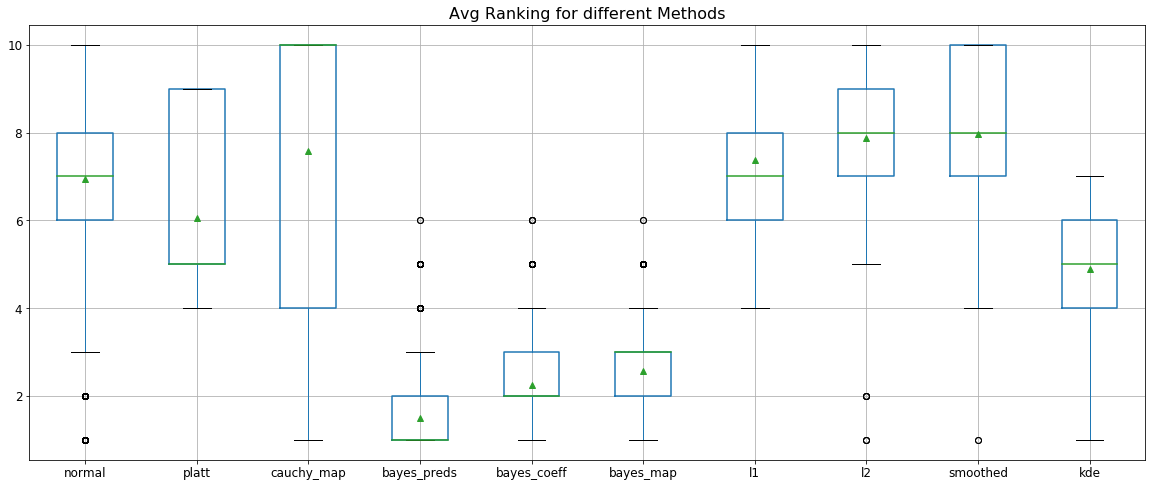

In [130]:
subresults1 = results[(results['clr'] == 0.7) & (results['tr_size'] == 100)]
subresults1.reset_index(drop=True, inplace=True)
avgRank_CE  = avgRank(subresults1, methods)
df = avgRank_CE
props = dict(boxes="b", whiskers="k", medians="k", caps="k", linewidth=2)
boxprops = dict(color="black",linewidth=1.5)
medianprops = dict(color="black",linewidth=1.5)
df.boxplot(grid = True, showmeans = True, notch = False, patch_artist=False, fontsize = 12, figsize=(20, 8),
           boxprops = boxprops, medianprops = medianprops)
           #color=props)

plt.title('Avg Ranking for different Methods', fontsize = 16)
plt.show()

#### Class Ratio  --> p = 0.9

C:\Users\s-moh\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


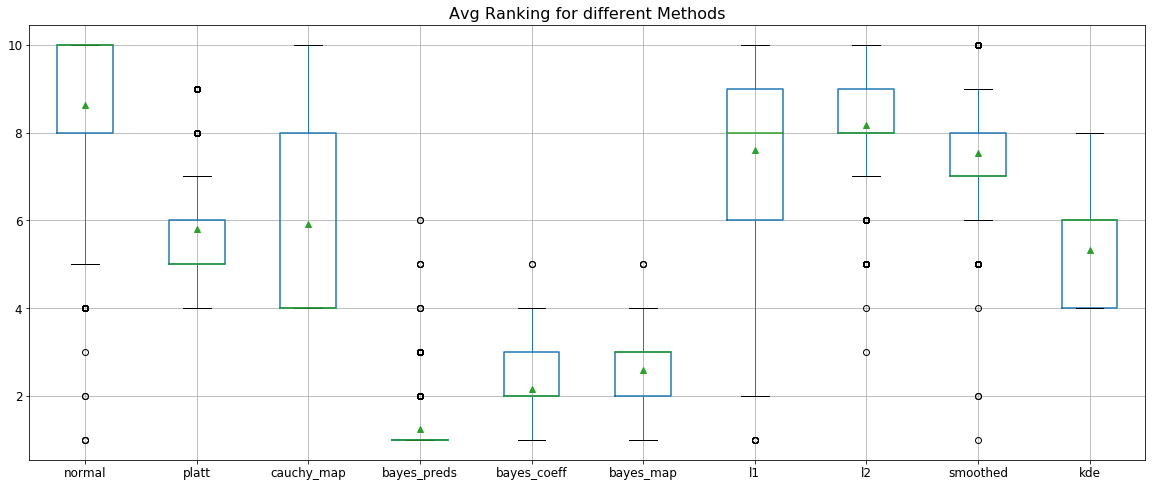

In [131]:
subresults1 = results[(results['clr'] == 0.9) & (results['tr_size'] == 100)]
subresults1.reset_index(drop=True, inplace=True)
avgRank_CE  = avgRank(subresults1, methods)
df = avgRank_CE
props = dict(boxes="b", whiskers="k", medians="k", caps="k", linewidth=2)
boxprops = dict(color="black",linewidth=1.5)
medianprops = dict(color="black",linewidth=1.5)
df.boxplot(grid = True, showmeans = True, notch = False, patch_artist=False, fontsize = 12, figsize=(20, 8),
           boxprops = boxprops, medianprops = medianprops)
           #color=props)

plt.title('Avg Ranking for different Methods', fontsize = 16)
plt.show()